In [ ]:
!pip install optuna
import plotly.express as px
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import torch.nn.functional as F
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, SubsetRandomSampler
from torch import nn
import optuna
import torch.optim as Optim
from sklearn.model_selection import KFold


In [ ]:
bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0,
              'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
### Download the data and create dataset
data_dir = 'datamset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
mean = 0.28604
std = 0.3205
tr = transforms.Compose(transforms=[transforms.ToTensor() ])
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True, transform=tr)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True,transform=tr)
complete_train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting datamset/FashionMNIST/raw/train-images-idx3-ubyte.gz to datamset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting datamset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to datamset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting datamset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to datamset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting datamset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to datamset/FashionMNIST/raw



In [ ]:
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
train_dataset, val_dataset = random_split(train_dataset, (50000, 10000))
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
validation_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [ ]:
class VAE(nn.Module):
    
    def __init__(self, encoded_space_dim=2,NumFL1=16,NumFL2=32,NumFL3=64,latent=65):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(in_channels=1, out_channels=NumFL1, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(in_channels=NumFL1, out_channels=NumFL2, kernel_size = 3,stride = 2, padding=1),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(in_channels=NumFL2, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
            nn.ReLU(True)
#             nn.Conv2d(in_channels=NumFL3, out_channels=NumFL3, kernel_size = 3,stride = 2, padding=0),
#             nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        
        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=3*3*NumFL3, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
#             nn.Linear(in_features=latent, out_features=encoded_space_dim)
        )
        ### variational part
        self.Mean = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        self.LogSigma = nn.Linear(in_features=latent,out_features=encoded_space_dim)
        ### 
        
        
        #--------------------------------------------------------------------------------------
        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(in_features=encoded_space_dim, out_features=latent),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(in_features=latent, out_features=3*3*NumFL3),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(NumFL3, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL3, out_channels=NumFL2, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL2, out_channels=NumFL1, kernel_size=3,stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(in_channels=NumFL1, out_channels=1, kernel_size=3,stride=2, padding=1, output_padding=1)
        )
    def distribution(self,mean,Logvariance):
            ebsilon = torch.randn_like(mean)# the same as torch.randn(mean.size[0],mean.size[1])
            return mean + ebsilon * torch.exp(Logvariance/2)
    def forward(self, x):
        x = self.encoder_cnn(x)# Apply convolutions
        x = self.flatten(x)# Flatten
        # # Apply linear layers
        x = self.encoder_lin(x)
        M = self.Mean(x)
        S = self.LogSigma(x)
        Z = self.distribution(M,S)
        # -----------------------------------------------
        #Apply linear layers
        x = self.decoder_lin(Z)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x,Z,M,S

In [ ]:
lossFunction = F.mse_loss

In [ ]:
def KL_Loss(mean,LogVar):
    kl_div = -0.5 * torch.sum(1 + LogVar - mean**2  - torch.exp(LogVar), axis=1) # sum over latent dimension
    batchsize = kl_div.size(0)
    kl_div = kl_div.mean()
    return kl_div,batchsize

In [ ]:
### Training function
def train_epoch_VAE(encoder, device, dataloader, loss_fn, optimizer,alpha):
    # Set train mode for both the encoder and the decoder
    encoder.train()
#     decoder.train()
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    batch_error = []
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)

        outImage,Z,mean,LogVar = encoder(image_batch)
        kl_loss,BatchSize = KL_Loss(mean,LogVar)
        loss = lossFunction(outImage, image_batch, reduction='none')
        loss = loss.view(BatchSize,-1).sum(axis = 1)
        loss = loss.mean()
        loss = alpha*loss + kl_loss
        batch_error.append(loss.item())
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return batch_error
        # Print batch loss
#         print('\t partial train loss (single batch): %f' % (loss.data))

In [ ]:
### Testing function
def test_epochVAE(encoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    batchValError = []
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            outImage,_,_,_= encoder(image_batch)
            
            # Append the network output and the original image to the lists
            conc_out.append(outImage.cpu())
            conc_label.append(image_batch.cpu())
            batchValError.append(loss_fn(outImage,image_batch).item())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data,batchValError

## Kfold cross validation error for VAE

In [ ]:
loss_fn = torch.nn.MSELoss()
alpha =1
k = 5 # number of folds
kfold = KFold(n_splits=k, shuffle=True)
kfoldErrors = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
    
    print(f'FOLD {fold+1}')
    print('------------------------------------------')
    torch.manual_seed(42)
    kfmodel = VAE(encoded_space_dim=2,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer'])).to(device)
    params_to_optimize = kfmodel.parameters()
    optim = torch.optim.Adam(params_to_optimize, lr=bestParams['lr'], weight_decay=1e-5)
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(train_dataset,batch_size=256, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(train_dataset,batch_size=256, 
                                             sampler=test_subsampler)
    for epoch in range(10):
        temp = train_epoch_VAE(encoder = kfmodel,device = device,dataloader = trainloader,
                               loss_fn = lossFunction,optimizer = optim,alpha=alpha)
        
    val_loss,batchvalerror = test_epochVAE(encoder=kfmodel,device=device,
                                           dataloader=testloader,loss_fn=lossFunction)
    kfoldErrors.append(val_loss)
    print(f"validation error for this fold is {val_loss}")
print("---------------------")
print(f"kfold cross validation error is {np.mean(kfoldErrors)}")
print("---------------------")

FOLD 1
------------------------------------------
validation error for this fold is 0.03166598826646805
FOLD 2
------------------------------------------
validation error for this fold is 0.03157438337802887
FOLD 3
------------------------------------------
validation error for this fold is 0.03174976631999016
FOLD 4
------------------------------------------
validation error for this fold is 0.030425745993852615
FOLD 5
------------------------------------------
validation error for this fold is 0.031199326738715172
---------------------
kfold cross validation error is 0.031323038041591644
---------------------


## training the VAE for 30 epochs

In [ ]:
encoded_space_dim = 2
bestParams = {'lr': 0.004748478691420016, 'optimizer': 'Adam', 'NumF1': 12.0,
              'NumF2': 24.0, 'NumF3': 48.0, 'latent_layer': 128.0}

VAEmodel = VAE(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))



In [ ]:
lr = bestParams['lr'] # Learning rate
optim = torch.optim.Adam(VAEmodel.parameters(), lr=lr)

VAEmodel.to(device)

VAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(24, 48, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=432, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (Mean): Linear(in_features=128, out_features=2, bias=True)
  (LogSigma): Linear(in_features=128, out_features=2, bias=True)
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=432, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(48, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(48, 24, kernel_size=(3, 3), stride=(2, 2))
    (

EPOCH 1/30


	 VALIDATION - EPOCH 1/30 - loss: 0.037079


EPOCH 2/30


	 VALIDATION - EPOCH 2/30 - loss: 0.034006


EPOCH 3/30


	 VALIDATION - EPOCH 3/30 - loss: 0.032622


EPOCH 4/30


	 VALIDATION - EPOCH 4/30 - loss: 0.033026


EPOCH 5/30


	 VALIDATION - EPOCH 5/30 - loss: 0.031654




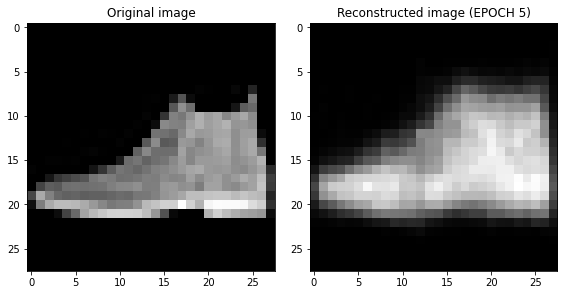

EPOCH 6/30


	 VALIDATION - EPOCH 6/30 - loss: 0.030834


EPOCH 7/30


	 VALIDATION - EPOCH 7/30 - loss: 0.030994


EPOCH 8/30


	 VALIDATION - EPOCH 8/30 - loss: 0.030430


EPOCH 9/30


	 VALIDATION - EPOCH 9/30 - loss: 0.030439


EPOCH 10/30


	 VALIDATION - EPOCH 10/30 - loss: 0.030058




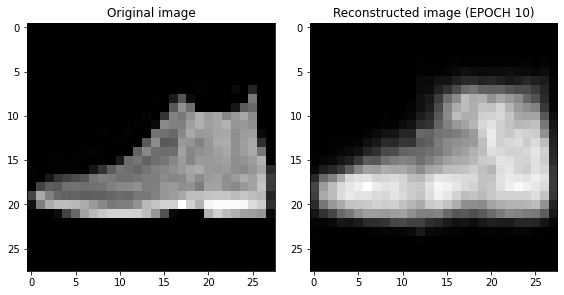

EPOCH 11/30


	 VALIDATION - EPOCH 11/30 - loss: 0.030564


EPOCH 12/30


	 VALIDATION - EPOCH 12/30 - loss: 0.029914


EPOCH 13/30


	 VALIDATION - EPOCH 13/30 - loss: 0.030232


EPOCH 14/30


	 VALIDATION - EPOCH 14/30 - loss: 0.029917


EPOCH 15/30


	 VALIDATION - EPOCH 15/30 - loss: 0.029540




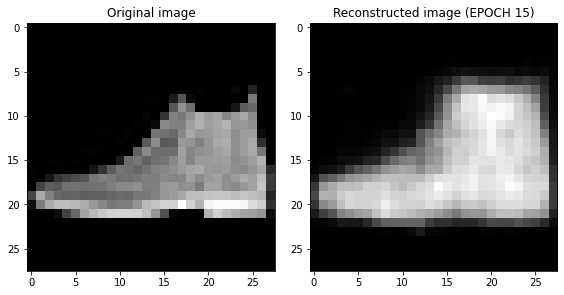

EPOCH 16/30


	 VALIDATION - EPOCH 16/30 - loss: 0.029723


EPOCH 17/30


	 VALIDATION - EPOCH 17/30 - loss: 0.029589


EPOCH 18/30


	 VALIDATION - EPOCH 18/30 - loss: 0.029430


EPOCH 19/30


	 VALIDATION - EPOCH 19/30 - loss: 0.029175


EPOCH 20/30


	 VALIDATION - EPOCH 20/30 - loss: 0.029004




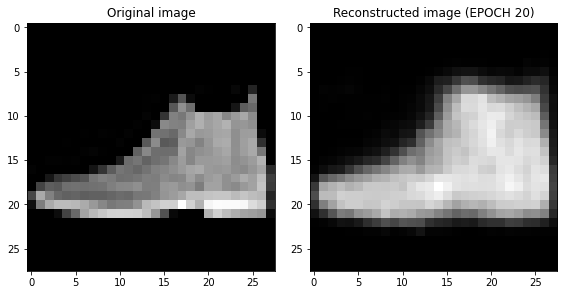

EPOCH 21/30


	 VALIDATION - EPOCH 21/30 - loss: 0.029172


EPOCH 22/30


	 VALIDATION - EPOCH 22/30 - loss: 0.029286


EPOCH 23/30


	 VALIDATION - EPOCH 23/30 - loss: 0.028698


EPOCH 24/30


	 VALIDATION - EPOCH 24/30 - loss: 0.029249


EPOCH 25/30


	 VALIDATION - EPOCH 25/30 - loss: 0.028732




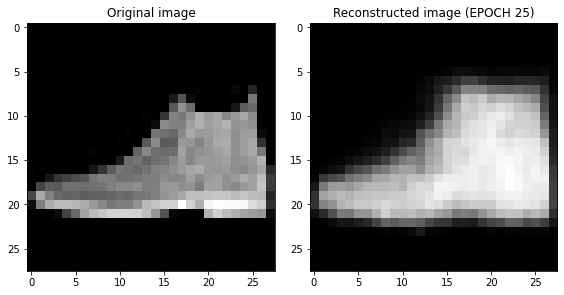

EPOCH 26/30


	 VALIDATION - EPOCH 26/30 - loss: 0.029040


EPOCH 27/30


	 VALIDATION - EPOCH 27/30 - loss: 0.028847


EPOCH 28/30


	 VALIDATION - EPOCH 28/30 - loss: 0.028978


EPOCH 29/30


	 VALIDATION - EPOCH 29/30 - loss: 0.028676


EPOCH 30/30


	 VALIDATION - EPOCH 30/30 - loss: 0.028432




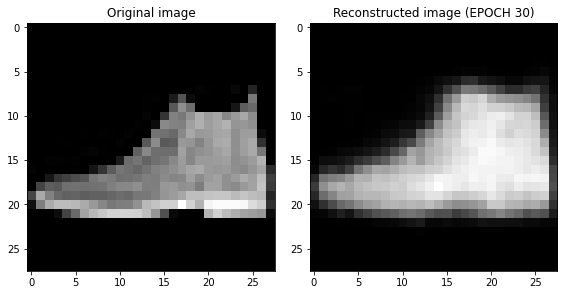

In [ ]:
### Training cycle
num_epochs = 30
alpha = 1
batchError = []
batchValError = []
validError = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    """" --------------- Training ---------------------"""
    temp = train_epoch_VAE(encoder = VAEmodel,device = device,dataloader = train_dataloader,loss_fn = lossFunction,optimizer = optim,alpha=alpha)
    for L in temp:
        batchError.append(L)
    ### Validation  (use the testing function)
    val_loss,batchvalerror = test_epochVAE(encoder=VAEmodel,device=device,dataloader=validation_dataloader,
                          loss_fn=lossFunction)
    for L in batchvalerror:
        batchValError.append(L)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    VAEmodel.eval()
#     decoder.eval()
    with torch.no_grad():
        rec_img,_,_,_  = VAEmodel(img)
    # Plot the reconstructed image every five epochs
    if (epoch+1)%5 == 0:
        fig, axs = plt.subplots(1, 2, figsize=(8,4))
        axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[0].set_title('Original image')
        axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
        axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
        plt.tight_layout()
        plt.pause(0.1)
        plt.show()
        plt.close()
    # Save network parameters
torch.save(VAEmodel.state_dict(), 'VAE.pth')

In [ ]:
PATH = "VAE2.pth"
from google.colab import files
torch.save(VAEmodel.state_dict(), PATH)
files.download('VAE2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Test error')

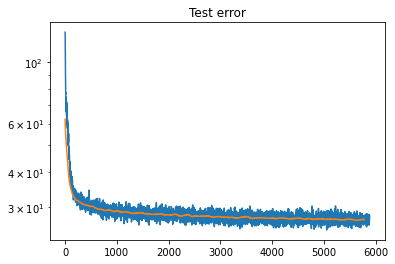

In [ ]:
n = 100
r = np.convolve(batchError, np.ones(n,)/n, mode='valid')
plt.semilogy(range(len(batchError)),(batchError))
plt.semilogy(range(len(r)),(r))
plt.title("Test error")


Text(0, 0.5, 'Erorr')

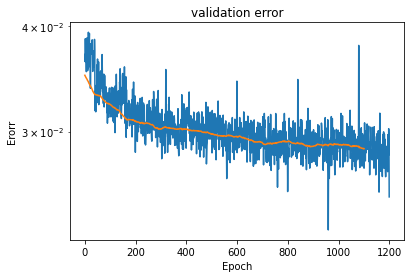

In [ ]:
n = 100
r = np.convolve(batchValError, np.ones(n,)/n, mode='valid')
plt.semilogy(range(len(batchValError)),(batchValError),label="validation error using AdamW optimizer")
plt.semilogy(range(len(r)),(r))
plt.title("validation error")
plt.xlabel("Epoch")
plt.ylabel("Erorr")

In [ ]:
finalTestErorr,_ = test_epochVAE(encoder=VAEmodel,device=device,dataloader=test_dataloader,
                          loss_fn=lossFunction)
print(f"-------> final test error of trained VAE is: {finalTestErorr}")

-------> final test error of trained VAE is: 0.028242215514183044


In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    VAEmodel.eval()
    with torch.no_grad():
        _,encoded_img,_,_  = VAEmodel(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:15<00:00, 627.46it/s]


In [ ]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  label
0            0.209773         0.990641      9
1            1.042061        -1.791162      2
2           -2.283791        -0.438997      1
3           -1.448179        -0.139722      1
4            0.494064        -0.106564      6
...               ...              ...    ...
9995         0.642967         0.704802      9
9996        -1.261417         0.255082      1
9997         0.000384         0.107143      8
9998        -1.903545         1.016302      1
9999        -0.585149         1.032205      5

[10000 rows x 3 columns]

In [ ]:
# ! pip install plotly
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',color=[label_names[l] for l in encoded_samples.label.to_numpy()], opacity=1)


## VAE with latent space of 3
in this part we train the VAE in previous part with latent space 3 and visualize the latent space. 

In [ ]:
encoded_space_dim = 3
bestParams = {'lr': 0.005, 'optimizer': 'Adam', 'NumF1': 16,'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
VAEmodel = VAE(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
lr = bestParams['lr'] # Learning rate
optim = torch.optim.Adam(VAEmodel.parameters(), lr=lr)

VAEmodel.to(device)

VAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=576, out_features=94, bias=True)
    (1): ReLU(inplace=True)
  )
  (Mean): Linear(in_features=94, out_features=3, bias=True)
  (LogSigma): Linear(in_features=94, out_features=3, bias=True)
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=94, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=94, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): R

EPOCH 1/30


	 VALIDATION - EPOCH 1/30 - loss: 0.030480




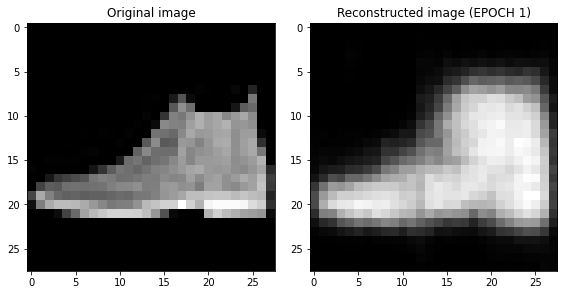

EPOCH 2/30


	 VALIDATION - EPOCH 2/30 - loss: 0.027387




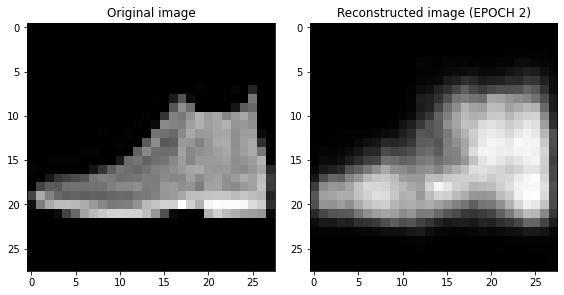

EPOCH 3/30


	 VALIDATION - EPOCH 3/30 - loss: 0.027724




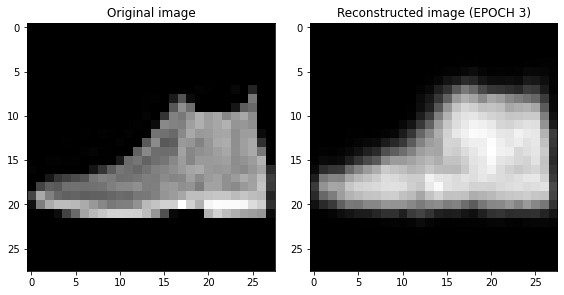

EPOCH 4/30


	 VALIDATION - EPOCH 4/30 - loss: 0.026364




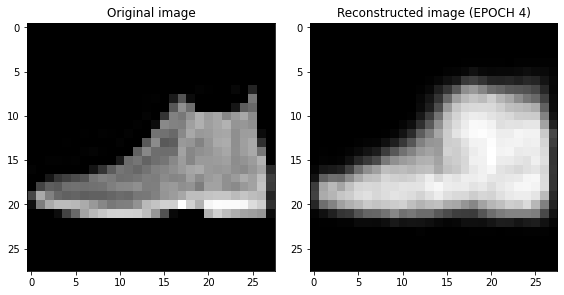

EPOCH 5/30


	 VALIDATION - EPOCH 5/30 - loss: 0.025965




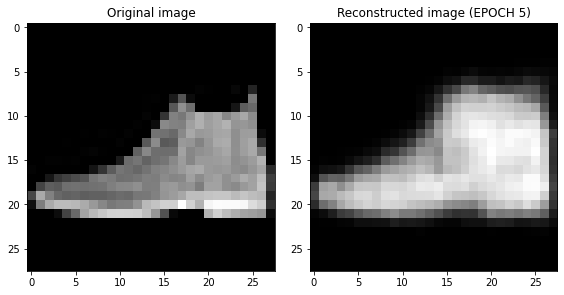

EPOCH 6/30


	 VALIDATION - EPOCH 6/30 - loss: 0.026009




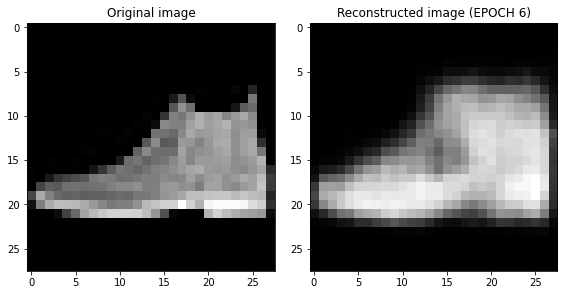

EPOCH 7/30


	 VALIDATION - EPOCH 7/30 - loss: 0.025682




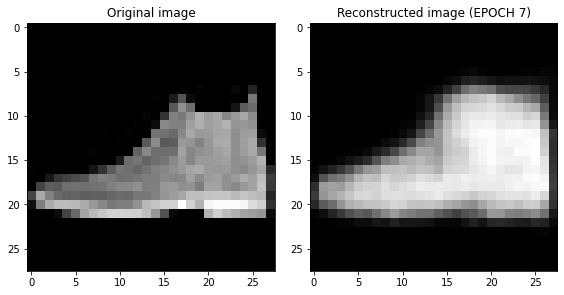

EPOCH 8/30


	 VALIDATION - EPOCH 8/30 - loss: 0.025187




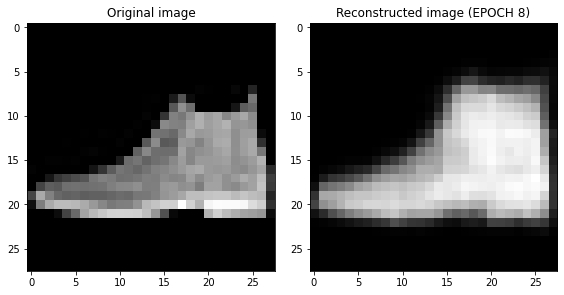

EPOCH 9/30


	 VALIDATION - EPOCH 9/30 - loss: 0.025929




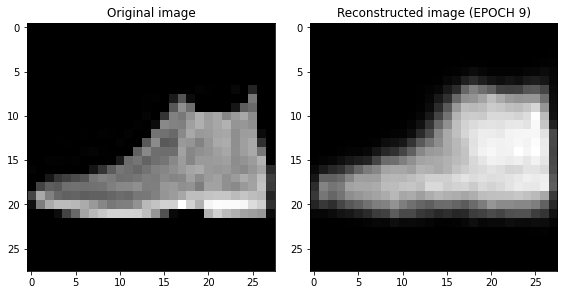

EPOCH 10/30


	 VALIDATION - EPOCH 10/30 - loss: 0.024736




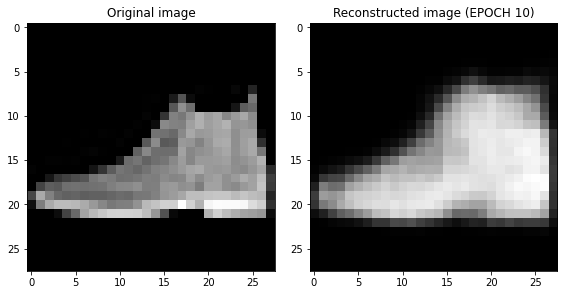

EPOCH 11/30


	 VALIDATION - EPOCH 11/30 - loss: 0.024625




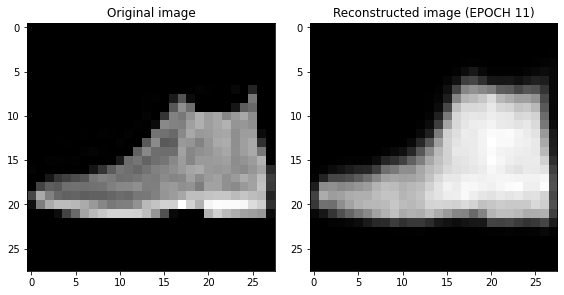

EPOCH 12/30


	 VALIDATION - EPOCH 12/30 - loss: 0.024761




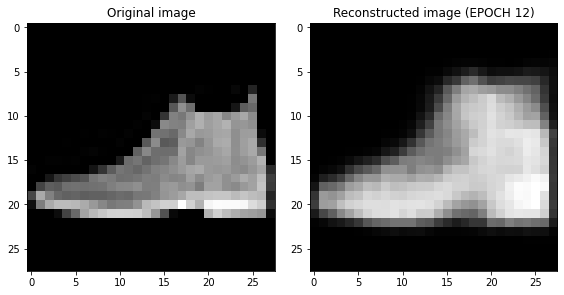

EPOCH 13/30


	 VALIDATION - EPOCH 13/30 - loss: 0.024719




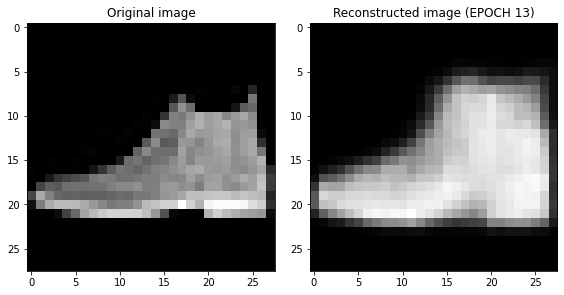

EPOCH 14/30


	 VALIDATION - EPOCH 14/30 - loss: 0.024971




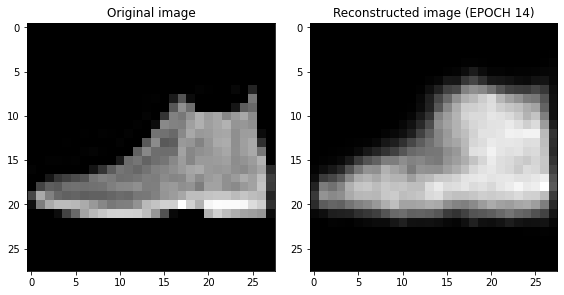

EPOCH 15/30


	 VALIDATION - EPOCH 15/30 - loss: 0.024199




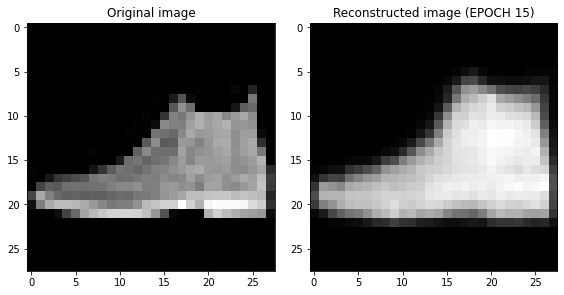

EPOCH 16/30


	 VALIDATION - EPOCH 16/30 - loss: 0.024807




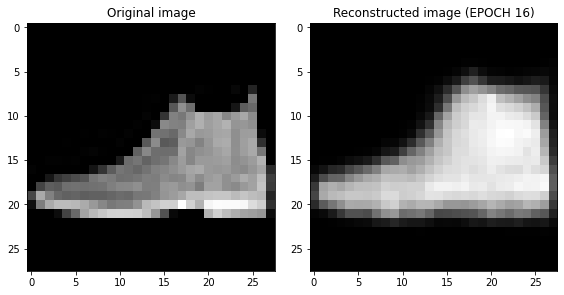

EPOCH 17/30


	 VALIDATION - EPOCH 17/30 - loss: 0.024225




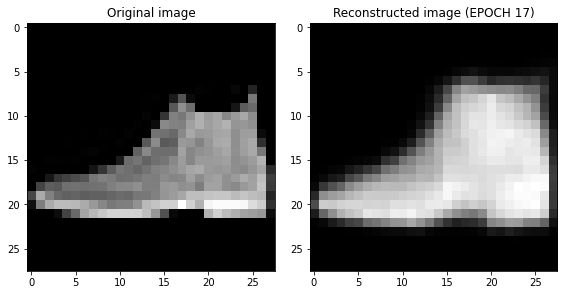

EPOCH 18/30


	 VALIDATION - EPOCH 18/30 - loss: 0.024085




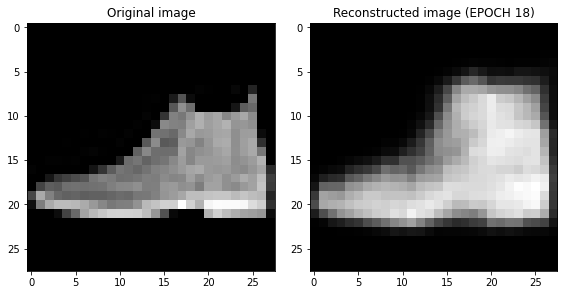

EPOCH 19/30


	 VALIDATION - EPOCH 19/30 - loss: 0.024259




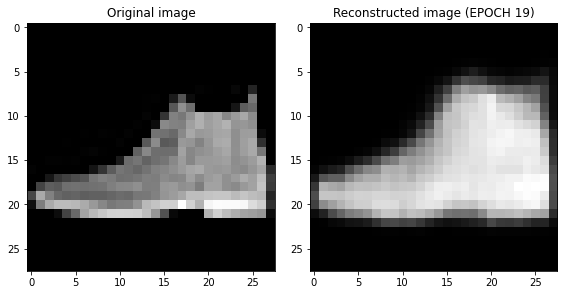

EPOCH 20/30


	 VALIDATION - EPOCH 20/30 - loss: 0.024449




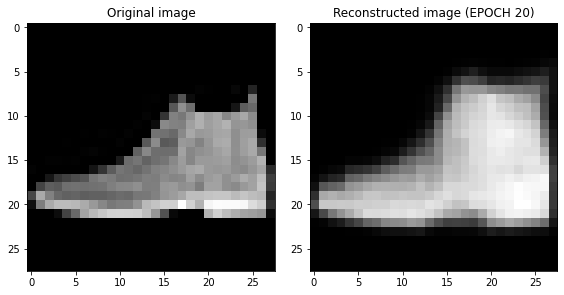

EPOCH 21/30


	 VALIDATION - EPOCH 21/30 - loss: 0.023945




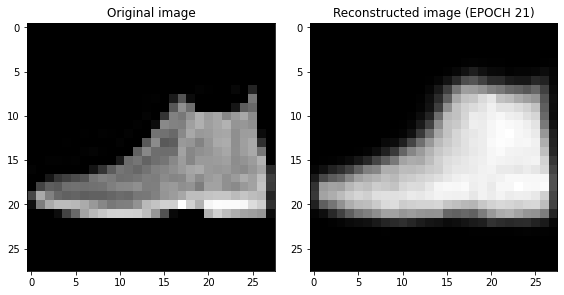

EPOCH 22/30


	 VALIDATION - EPOCH 22/30 - loss: 0.023843




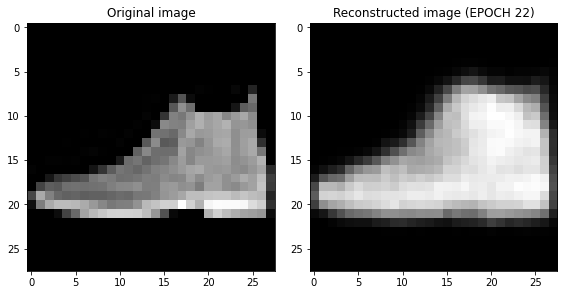

EPOCH 23/30


	 VALIDATION - EPOCH 23/30 - loss: 0.024644




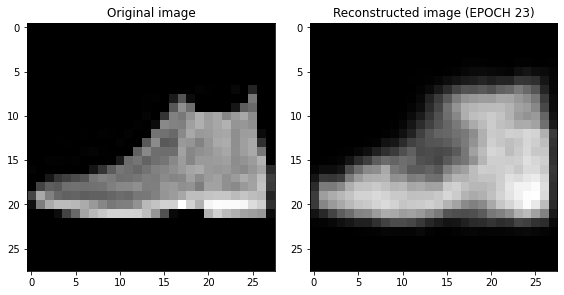

EPOCH 24/30


	 VALIDATION - EPOCH 24/30 - loss: 0.023942




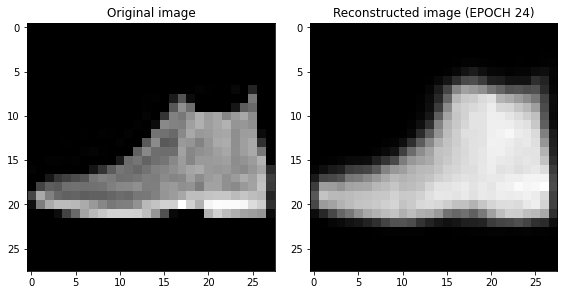

EPOCH 25/30


	 VALIDATION - EPOCH 25/30 - loss: 0.023960




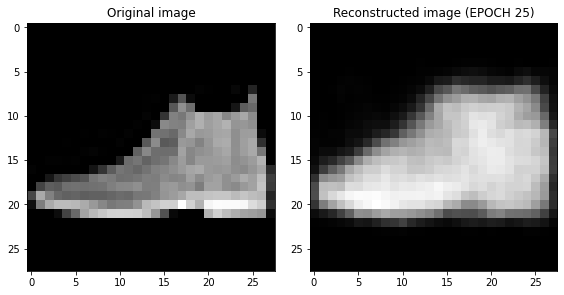

EPOCH 26/30


	 VALIDATION - EPOCH 26/30 - loss: 0.023988




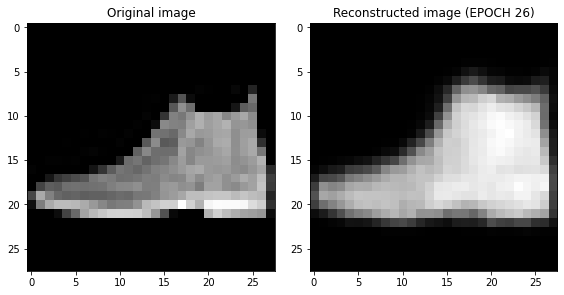

EPOCH 27/30


	 VALIDATION - EPOCH 27/30 - loss: 0.023762




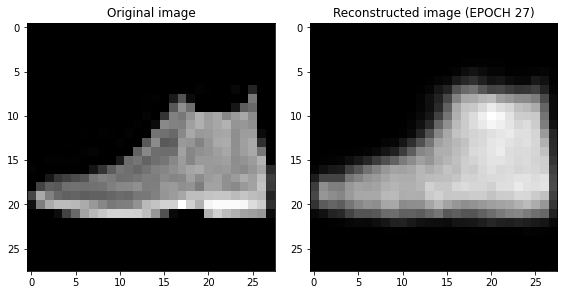

EPOCH 28/30


	 VALIDATION - EPOCH 28/30 - loss: 0.024046




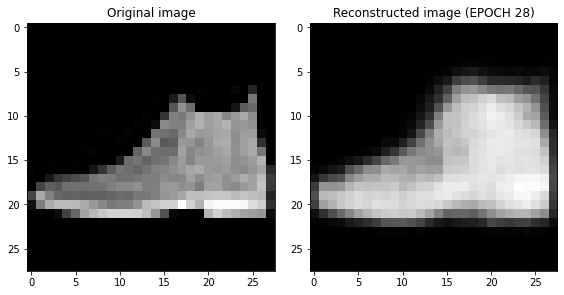

EPOCH 29/30


	 VALIDATION - EPOCH 29/30 - loss: 0.024013




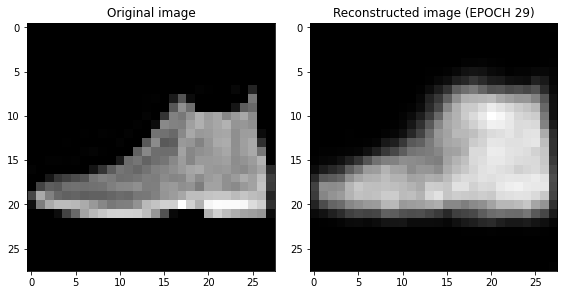

EPOCH 30/30


	 VALIDATION - EPOCH 30/30 - loss: 0.024204




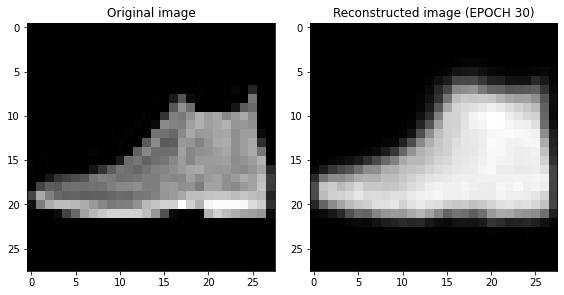

In [ ]:
### Training cycle
num_epochs = 30
alpha = 1
batchError = []
batchValError = []
validError = []
for epoch in range(num_epochs):
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    
    """" --------------- Training ---------------------"""
    temp = train_epoch_VAE(encoder = VAEmodel,device = device,dataloader = train_dataloader,loss_fn = lossFunction,optimizer = optim,alpha=alpha)
    for L in temp:
        batchError.append(L)
    ### Validation  (use the testing function)
    val_loss,batchvalerror = test_epochVAE(encoder=VAEmodel,device=device,dataloader=test_dataloader,
                          loss_fn=lossFunction)
    for L in batchvalerror:
        batchValError.append(L)
    # Print Validationloss
    print('\n\n\t VALIDATION - EPOCH %d/%d - loss: %f\n\n' % (epoch + 1, num_epochs, val_loss))

    ### Plot progress
    # Get the output of a specific image (the test image at index 0 in this case)
    img = test_dataset[0][0].unsqueeze(0).to(device)
    VAEmodel.eval()
#     decoder.eval()
    with torch.no_grad():
        rec_img,_,_,_  = VAEmodel(img)
    # Plot the reconstructed image
    fig, axs = plt.subplots(1, 2, figsize=(8,4))
    axs[0].imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[0].set_title('Original image')
    axs[1].imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
    axs[1].set_title('Reconstructed image (EPOCH %d)' % (epoch + 1))
    plt.tight_layout()
    plt.pause(0.1)
    # Save figures
    os.makedirs('autoencoder_progress_%d_features' % encoded_space_dim, exist_ok=True)
    fig.savefig('autoencoder_progress_%d_features/epoch_%d.jpg' % (encoded_space_dim, epoch + 1))
    plt.show()
    plt.close()

    # Save network parameters
    torch.save(VAEmodel.state_dict(), 'encoder_params.pth')
#     torch.save(decoder.state_dict(), 'decoder_params.pth')

    # NOTE: Remember to save also the parameters of the optimizer if you want to restore and continue the training

In [ ]:
# save the trained VAE with 3D latent space 
PATH = "VAE3.pth"
from google.colab import files
torch.save(VAEmodel.state_dict(), PATH)
files.download('VAE3.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# load the trained VAE with 3D latent space
encoded_space_dim = 3
bestParams = {'lr': 0.005, 'optimizer': 'Adam', 'NumF1': 16,'NumF2': 32, 'NumF3': 64, 'latent_layer': 94}
VAEmodel = VAE(encoded_space_dim=encoded_space_dim,NumFL1=int(bestParams['NumF1']),NumFL2=int(bestParams['NumF2']),
                   NumFL3=int(bestParams['NumF3']),latent=int(bestParams['latent_layer']))
lr = bestParams['lr'] # Learning rate
VAEmodel.load_state_dict(torch.load(PATH)) 

optim = torch.optim.Adam(VAEmodel.parameters(), lr=lr)

VAEmodel.to(device)

VAE(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encoder_lin): Sequential(
    (0): Linear(in_features=576, out_features=94, bias=True)
    (1): ReLU(inplace=True)
  )
  (Mean): Linear(in_features=94, out_features=3, bias=True)
  (LogSigma): Linear(in_features=94, out_features=3, bias=True)
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=94, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=94, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): R

In [ ]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(train_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    VAEmodel.eval()
    with torch.no_grad():
        _,encoded_img,_,_  = VAEmodel(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samplesVAE3 = pd.DataFrame(encoded_samples)

100%|██████████| 60000/60000 [00:56<00:00, 1066.42it/s]


In [ ]:
px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',z='Enc. Variable 2',color=[label_names[l] for l in encoded_samplesVAE3.label.to_numpy()], opacity=1)


In [ ]:
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.decoder_lin = (VAEmodel.decoder_lin)
        self.unflatten = (VAEmodel.unflatten)
        self.decoder_conv = VAEmodel.decoder_conv
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        return x

In [ ]:
Generator = generator()
Generator.to(device)

generator(
  (decoder_lin): Sequential(
    (0): Linear(in_features=3, out_features=94, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=94, out_features=576, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(64, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [ ]:
num_preds = 16
mu = torch.Tensor([0,0,0])
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(mu))
Z = p.rsample((num_preds,))

z = torch.Tensor([2.3,-1,.2]).float()
z = z.unsqueeze(0).to(device)
# SAMPLE IMAGES
print(z)
with torch.no_grad():
    pred = Generator(Z).cpu()

tensor([[ 2.3000, -1.0000,  0.2000]])


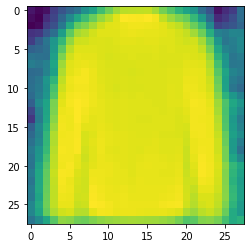

In [ ]:
plt.imshow(pred.squeeze()[10])